In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

/u/kazumak2/.conda/envs/pytorch-env/lib/python3.9/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/baseline'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from helper import convert2dim, plot_three_samples_pred_err

## Analysis of Single/Multi Branch Architectures

In [3]:
# Data directories
sdata_dir = 'analysis/baseline/single_branch/array/'
mdata_dir = 'analysis/baseline/multi_branch/array/'

# Load single-branch GRU/LSTM results
sgru_7 = np.load(sdata_dir + 'gru_window_7_preds_targets.npy')
sgru_30 = np.load(sdata_dir + 'gru_window_30_preds_targets.npy')
sgru_60 = np.load(sdata_dir + 'gru_window_60_preds_targets.npy')
sgru_90 = np.load(sdata_dir + 'gru_window_90_preds_targets.npy')

slstm_7 = np.load(sdata_dir + 'lstm_window_7_preds_targets.npy')
slstm_30 = np.load(sdata_dir + 'lstm_window_30_preds_targets.npy')
slstm_60 = np.load(sdata_dir + 'lstm_window_60_preds_targets.npy')
slstm_90 = np.load(sdata_dir + 'lstm_window_90_preds_targets.npy')

fnn_7 = np.load(sdata_dir + 'fnn_window_7_preds_targets.npy')
fnn_30 = np.load(sdata_dir + 'fnn_window_30_preds_targets.npy')
fnn_60 = np.load(sdata_dir + 'fnn_window_60_preds_targets.npy')
fnn_90 = np.load(sdata_dir + 'fnn_window_90_preds_targets.npy')

# Load multi-branch GRU/LSTM results
mgru_7 = np.load(mdata_dir + 'gru_window_7_preds_targets.npy')
mgru_30 = np.load(mdata_dir + 'gru_window_30_preds_targets.npy')
mgru_60 = np.load(mdata_dir + 'gru_window_60_preds_targets.npy')
mgru_90 = np.load(mdata_dir + 'gru_window_90_preds_targets.npy')

mlstm_7 = np.load(mdata_dir + 'lstm_window_7_preds_targets.npy')
mlstm_30 = np.load(mdata_dir + 'lstm_window_30_preds_targets.npy')
mlstm_60 = np.load(mdata_dir + 'lstm_window_60_preds_targets.npy')
mlstm_90 = np.load(mdata_dir + 'lstm_window_90_preds_targets.npy')


In [4]:
# compute relative l2 error per sample (samples, (pred, target), grid points)
def relative_l2_error(data):
    preds = data[:, 0, :]
    targets = data[:, 1, :]
    l2_errors = np.linalg.norm(preds - targets, axis=1)
    target_norms = np.linalg.norm(targets, axis=1)
    relative_errors = l2_errors / target_norms * 100
    return relative_errors

def RMSE(data):
    preds = data[:, 0, :]
    targets = data[:, 1, :]
    mse = np.mean((preds - targets) ** 2, axis=1)
    rmse = np.sqrt(mse)
    return rmse

def MAE(data):
    preds = data[:, 0, :]
    targets = data[:, 1, :]
    mae = np.mean(np.abs(preds - targets), axis=1)
    return mae

def SSIM(data):
    lon, lat, pred = convert2dim(data[:,0,:])  # just to load the convert2dim function
    _, _,   target = convert2dim(data[:,1,:])  # just to load the convert2dim function
    from skimage.metrics import structural_similarity as ssim
    ssim_values = []
    for i in range(pred.shape[0]):
        ssim_index = ssim(target[i,:,:], pred[i,:,:], data_range=target[i,:,:].max() - target[i,:,:].min())
        ssim_values.append(ssim_index)
    return np.array(ssim_values)

In [5]:
# compute all metrics for all models and windows
def compute_metrics(data):
    rel_l2 = relative_l2_error(data)
    rmse = RMSE(data)
    mae = MAE(data)
    ssim_vals = SSIM(data)
    return rel_l2, rmse, mae, ssim_vals


data_sets = {
    'Single-branch GRU': [sgru_7, sgru_30, sgru_60, sgru_90],
    'Single-branch LSTM': [slstm_7, slstm_30, slstm_60, slstm_90],
    'Single-branch FNN': [fnn_7, fnn_30, fnn_60, fnn_90],
    'Multi-branch GRU': [mgru_7, mgru_30, mgru_60, mgru_90],
    'Multi-branch LSTM': [mlstm_7, mlstm_30, mlstm_60, mlstm_90],
}


# get metrics
metrics = {}
for model_name, datasets in data_sets.items():
    print(f"Computing metrics for {model_name}...")
    model_metrics = []
    for data in datasets:
        model_metrics.append(compute_metrics(data))
    metrics[model_name] = model_metrics  # list of tuples per window

Computing metrics for Single-branch GRU...
Computing metrics for Single-branch LSTM...
Computing metrics for Single-branch FNN...
Computing metrics for Multi-branch GRU...
Computing metrics for Multi-branch LSTM...


In [6]:
# [seq_length][metrics]
metrics_name = ['Relative L2 error', 'RMSE', 'MAE', 'SSIM']
models = ['Single-branch GRU', 'Single-branch LSTM', 'Single-branch FNN', 'Multi-branch GRU', 'Multi-branch LSTM']

print("\nAverage Metrics Summary:\n")
print(metrics_name)

for model in models:
    print(f"Model: {model}")
    for i, W in enumerate([7, 30, 60, 90]):
        print(f"  Sequence Length: {W} days")
        print(metrics[model][i][0].mean(), metrics[model][i][1].mean(), metrics[model][i][2].mean(), metrics[model][i][3].mean())
    print("")


Average Metrics Summary:

['Relative L2 error', 'RMSE', 'MAE', 'SSIM']
Model: Single-branch GRU
  Sequence Length: 7 days
0.1001132 3.369726e-05 2.8390712e-05 0.9995456498618227
  Sequence Length: 30 days
0.10889865 3.6641926e-05 2.9740919e-05 0.9993603001328215
  Sequence Length: 60 days
0.09952117 3.351009e-05 2.72788e-05 0.999429258802855
  Sequence Length: 90 days
0.08517963 2.868338e-05 2.3206318e-05 0.9995548420770826

Model: Single-branch LSTM
  Sequence Length: 7 days
0.11237724 3.780052e-05 3.1108237e-05 0.9993697437164148
  Sequence Length: 30 days
0.09586354 3.227427e-05 2.5874908e-05 0.999424372401634
  Sequence Length: 60 days
0.09218127 3.1028118e-05 2.4852907e-05 0.9994860559941613
  Sequence Length: 90 days
0.09695311 3.2661243e-05 2.6125263e-05 0.9994452371493304

Model: Single-branch FNN
  Sequence Length: 7 days
0.18652613 6.264526e-05 5.0494247e-05 0.9989335745832832
  Sequence Length: 30 days
0.12846686 4.322611e-05 3.556247e-05 0.9991445874172273
  Sequence Lengt

Mean + Std of Relative L2 Errors (%):
S-GRU 7: 0.100 ± 0.029, 30: 0.109 ± 0.031, 60: 0.100 ± 0.018, 90: 0.085 ± 0.018
S-LSTM 7: 0.112 ± 0.029, 30: 0.096 ± 0.019, 60: 0.092 ± 0.019, 90: 0.097 ± 0.020
M-GRU 7: 0.898 ± 0.608, 30: 0.755 ± 0.549, 60: 0.747 ± 0.511, 90: 0.777 ± 0.549
M-LSTM 7: 0.624 ± 0.452, 30: 0.793 ± 0.546, 60: 0.634 ± 0.496, 90: 1.198 ± 0.718
FNN 7: 0.187 ± 0.068, 30: 0.128 ± 0.033, 60: 0.188 ± 0.064, 90: 0.193 ± 0.074


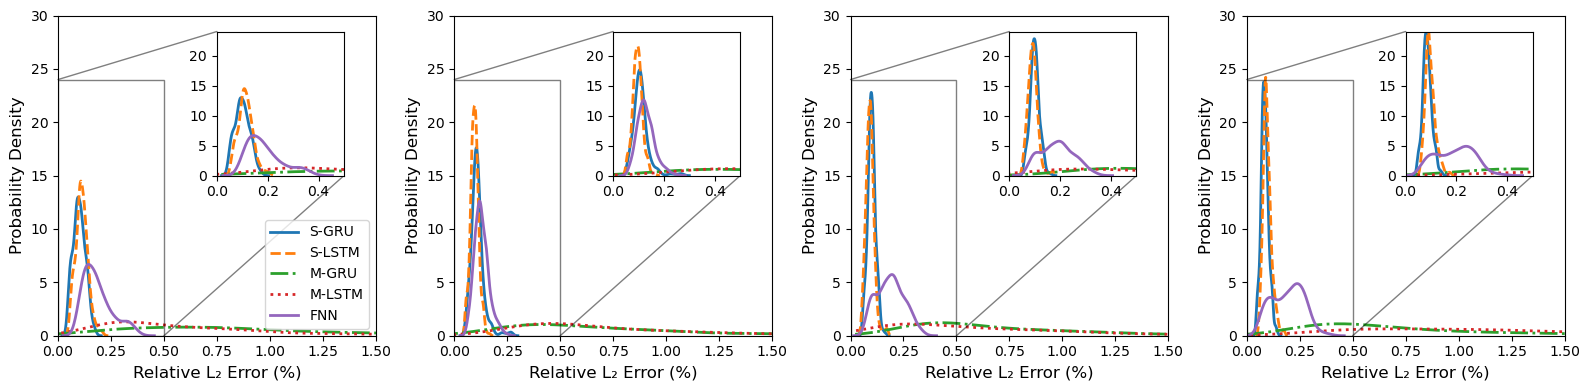

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# compute relative l2 error per sample (samples, (pred, target), grid points)
def relative_l2_error(data):
    preds = data[:, 0, :]
    targets = data[:, 1, :]
    l2_errors = np.linalg.norm(preds - targets, axis=1)
    target_norms = np.linalg.norm(targets, axis=1)
    relative_errors = l2_errors / target_norms * 100
    return relative_errors

# get relative errors for all models
sgru_7_err = relative_l2_error(sgru_7)
sgru_30_err = relative_l2_error(sgru_30)
sgru_60_err = relative_l2_error(sgru_60)
sgru_90_err = relative_l2_error(sgru_90)

slstm_7_err = relative_l2_error(slstm_7)
slstm_30_err = relative_l2_error(slstm_30)
slstm_60_err = relative_l2_error(slstm_60)
slstm_90_err = relative_l2_error(slstm_90)

fnn_7_err = relative_l2_error(fnn_7)
fnn_30_err = relative_l2_error(fnn_30)
fnn_60_err = relative_l2_error(fnn_60)
fnn_90_err = relative_l2_error(fnn_90)

mgru_7_err = relative_l2_error(mgru_7)
mgru_30_err = relative_l2_error(mgru_30)
mgru_60_err = relative_l2_error(mgru_60)
mgru_90_err = relative_l2_error(mgru_90)

mlstm_7_err = relative_l2_error(mlstm_7)
mlstm_30_err = relative_l2_error(mlstm_30)
mlstm_60_err = relative_l2_error(mlstm_60)
mlstm_90_err = relative_l2_error(mlstm_90)

# print mean + std of relative errors
print("Mean + Std of Relative L2 Errors (%):")
print(f"S-GRU 7: {np.mean(sgru_7_err):.3f} ± {np.std(sgru_7_err):.3f}"
      f", 30: {np.mean(sgru_30_err):.3f} ± {np.std(sgru_30_err):.3f}"
        f", 60: {np.mean(sgru_60_err):.3f} ± {np.std(sgru_60_err):.3f}"
          f", 90: {np.mean(sgru_90_err):.3f} ± {np.std(sgru_90_err):.3f}")
print(f"S-LSTM 7: {np.mean(slstm_7_err):.3f} ± {np.std(slstm_7_err):.3f}"
      f", 30: {np.mean(slstm_30_err):.3f} ± {np.std(slstm_30_err):.3f}"
        f", 60: {np.mean(slstm_60_err):.3f} ± {np.std(slstm_60_err):.3f}"
          f", 90: {np.mean(slstm_90_err):.3f} ± {np.std(slstm_90_err):.3f}")
print(f"M-GRU 7: {np.mean(mgru_7_err):.3f} ± {np.std(mgru_7_err):.3f}"
      f", 30: {np.mean(mgru_30_err):.3f} ± {np.std(mgru_30_err):.3f}"
        f", 60: {np.mean(mgru_60_err):.3f} ± {np.std(mgru_60_err):.3f}"
          f", 90: {np.mean(mgru_90_err):.3f} ± {np.std(mgru_90_err):.3f}")
print(f"M-LSTM 7: {np.mean(mlstm_7_err):.3f} ± {np.std(mlstm_7_err):.3f}"
      f", 30: {np.mean(mlstm_30_err):.3f} ± {np.std(mlstm_30_err):.3f}"
        f", 60: {np.mean(mlstm_60_err):.3f} ± {np.std(mlstm_60_err):.3f}"
          f", 90: {np.mean(mlstm_90_err):.3f} ± {np.std(mlstm_90_err):.3f}")
print(f"FNN 7: {np.mean(fnn_7_err):.3f} ± {np.std(fnn_7_err):.3f}"
      f", 30: {np.mean(fnn_30_err):.3f} ± {np.std(fnn_30_err):.3f}"
        f", 60: {np.mean(fnn_60_err):.3f} ± {np.std(fnn_60_err):.3f}"
          f", 90: {np.mean(fnn_90_err):.3f} ± {np.std(fnn_90_err):.3f}")

#----
# Sequence labels
#sequence_labels = ["(a)", "(b)", "(c)", "(d)"]

# Line styles for each model
line_styles = ["-", "--", "-.", ":", "-"]

# Model names
model_labels = ["S-GRU", "S-LSTM", "M-GRU", "M-LSTM", "FNN"]

# Corresponding sequence lengths
sequence_lengths = [7, 30, 60, 90]


# Extracted L₂ error for each sequence length
data_list = [[sgru_7_err, slstm_7_err, mgru_7_err, mlstm_7_err, fnn_7_err],
             [sgru_30_err, slstm_30_err, mgru_30_err, mlstm_30_err, fnn_30_err],
             [sgru_60_err, slstm_60_err, mgru_60_err, mlstm_60_err, fnn_60_err],
             [sgru_90_err, slstm_90_err, mgru_90_err, mlstm_90_err, fnn_90_err]]

# Create 1x4 subplots
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

# Loop through each panel to plot L₂ Error for different sequence lengths
for i, ax in enumerate(ax.flat):
    for data, label, ls in zip(data_list[i], model_labels, line_styles):
        sns.kdeplot(data, ax=ax, label=label, linestyle=ls, linewidth=2)

    ax.set_xlabel("Relative L₂ Error (%)", fontsize=12)
    ax.set_ylabel("Probability Density", fontsize=12)
    ax.set_xlim([0, 1.5])  # Limit x-axis to 0-25
    ax.set_ylim([0, 30])  # Limit y-axis to 0-3

    #ax.text(-0.1, 1.05, sequence_labels[i], transform=ax.transAxes, 
    #        fontsize=25, fontweight='bold')  # Panel label (a, b, c, d)
    
    # Only show legend in the first panel (a)
    if i == 0:
        ax.legend(fontsize=10, loc='lower right')
    else:
        ax.legend().set_visible(False)


    # Define zoom-in region
    x_zoom_min, x_zoom_max = 0, 0.5  # Region of interest for zooming

    # Adding zoomed-in inset (all models)
    axins = ax.inset_axes([0.5, 0.5, 0.4, 0.45])  # x, y, width, height
    for data, label, ls in zip(data_list[i], model_labels, line_styles):
        sns.kdeplot(data, ax=axins, label=label, linestyle=ls, linewidth=2)

    axins.set_xlim(x_zoom_min, x_zoom_max)  # Limit x-axis
    axins.set_ylim(0, 24)  # Limit y-axis
    axins.set_ylabel("")

    
    # Connect zoomed-in region to main plot
    ax.indicate_inset_zoom(axins, edgecolor="black")

    ## Add shaded regions to indicate low, medium, and high error areas
    #ax.axvspan(0, 0.5, color='green', alpha=0.2, label='Low Error')  # Low error zone
    #ax.axvspan(0.5, 1.5, color='yellow', alpha=0.2, label='Medium Error')  # Medium error
    #ax.axvspan(1.5, 2.5, color='red', alpha=0.2, label='High Error')  # High error
#
    ## Add labels for error zones
    #ax.text(0.10, 27, 'Low Error', color='black', fontsize=10)
    #ax.text(0.80, 27, 'Medium Error', color='black', fontsize=10)
    #ax.text(1.60, 27, 'High Error', color='black', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

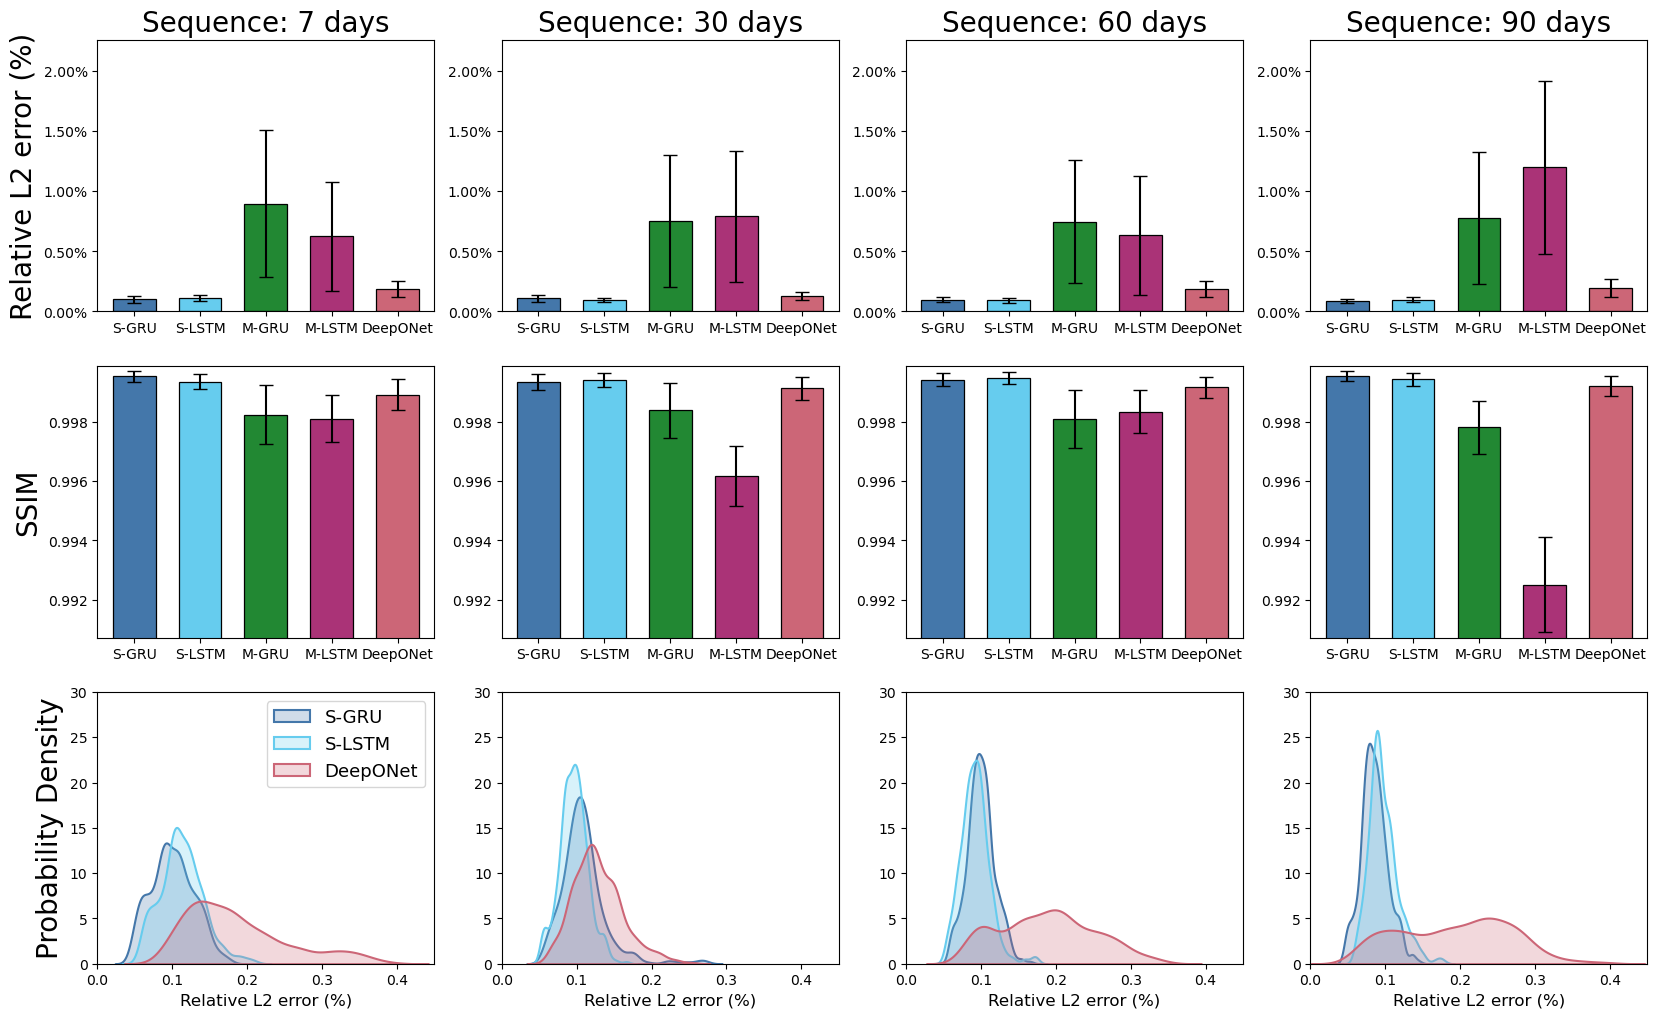

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns

# ---------------------------------------------------------------------
# REQUIRED INPUTS (already computed in your notebook/script)
#   metrics: dict with keys like 'Single-branch GRU', etc.
#   Each metrics[model][w_idx] returns a tuple where:
#     [0] -> array of rel-L2 (%) across samples
#     [3] -> array of SSIM across samples
# Window order: w_idx = 0,1,2,3 corresponds to W in [7,30,60,90]
# ---------------------------------------------------------------------
models  = ["S-GRU", "S-LSTM", "M-GRU", "M-LSTM", "DeepONet"]
windows = [7, 30, 60, 90]
models_hist = ["S-GRU", "S-LSTM", "DeepONet"]  # only these for KDE row

# ---------- helper to pull arrays by (model name, window index, metric index) ----------
def arr(model_key, w_idx, metric_idx):
    return metrics[model_key][w_idx][metric_idx]

# Build mean/std dicts for L2 (%)
mean_by_W_l2 = {
    7:  [arr('Single-branch GRU', 0, 0).mean(),
         arr('Single-branch LSTM',0, 0).mean(),
         arr('Multi-branch GRU',  0, 0).mean(),
         arr('Multi-branch LSTM', 0, 0).mean(),
         arr('Single-branch FNN', 0, 0).mean()],
    30: [arr('Single-branch GRU', 1, 0).mean(),
         arr('Single-branch LSTM',1, 0).mean(),
         arr('Multi-branch GRU',  1, 0).mean(),
         arr('Multi-branch LSTM', 1, 0).mean(),
         arr('Single-branch FNN', 1, 0).mean()],
    60: [arr('Single-branch GRU', 2, 0).mean(),
         arr('Single-branch LSTM',2, 0).mean(),
         arr('Multi-branch GRU',  2, 0).mean(),
         arr('Multi-branch LSTM', 2, 0).mean(),
         arr('Single-branch FNN', 2, 0).mean()],
    90: [arr('Single-branch GRU', 3, 0).mean(),
         arr('Single-branch LSTM',3, 0).mean(),
         arr('Multi-branch GRU',  3, 0).mean(),
         arr('Multi-branch LSTM', 3, 0).mean(),
         arr('Single-branch FNN', 3, 0).mean()],
}
std_by_W_l2 = {
    7:  [arr('Single-branch GRU', 0, 0).std(),
         arr('Single-branch LSTM',0, 0).std(),
         arr('Multi-branch GRU',  0, 0).std(),
         arr('Multi-branch LSTM', 0, 0).std(),
         arr('Single-branch FNN', 0, 0).std()],
    30: [arr('Single-branch GRU', 1, 0).std(),
         arr('Single-branch LSTM',1, 0).std(),
         arr('Multi-branch GRU',  1, 0).std(),
         arr('Multi-branch LSTM', 1, 0).std(),
         arr('Single-branch FNN', 1, 0).std()],
    60: [arr('Single-branch GRU', 2, 0).std(),
         arr('Single-branch LSTM',2, 0).std(),
         arr('Multi-branch GRU',  2, 0).std(),
         arr('Multi-branch LSTM', 2, 0).std(),
         arr('Single-branch FNN', 2, 0).std()],
    90: [arr('Single-branch GRU', 3, 0).std(),
         arr('Single-branch LSTM',3, 0).std(),
         arr('Multi-branch GRU',  3, 0).std(),
         arr('Multi-branch LSTM', 3, 0).std(),
         arr('Single-branch FNN', 3, 0).std()],
}

# Build mean/std dicts for SSIM
mean_by_W_ssim = {
    7:  [arr('Single-branch GRU', 0, 3).mean(),
         arr('Single-branch LSTM',0, 3).mean(),
         arr('Multi-branch GRU',  0, 3).mean(),
         arr('Multi-branch LSTM', 0, 3).mean(),
         arr('Single-branch FNN', 0, 3).mean()],
    30: [arr('Single-branch GRU', 1, 3).mean(),
         arr('Single-branch LSTM',1, 3).mean(),
         arr('Multi-branch GRU',  1, 3).mean(),
         arr('Multi-branch LSTM', 1, 3).mean(),
         arr('Single-branch FNN', 1, 3).mean()],
    60: [arr('Single-branch GRU', 2, 3).mean(),
         arr('Single-branch LSTM',2, 3).mean(),
         arr('Multi-branch GRU',  2, 3).mean(),
         arr('Multi-branch LSTM', 2, 3).mean(),
         arr('Single-branch FNN', 2, 3).mean()],
    90: [arr('Single-branch GRU', 3, 3).mean(),
         arr('Single-branch LSTM',3, 3).mean(),
         arr('Multi-branch GRU',  3, 3).mean(),
         arr('Multi-branch LSTM', 3, 3).mean(),
         arr('Single-branch FNN', 3, 3).mean()],
}
std_by_W_ssim = {
    7:  [arr('Single-branch GRU', 0, 3).std(),
         arr('Single-branch LSTM',0, 3).std(),
         arr('Multi-branch GRU',  0, 3).std(),
         arr('Multi-branch LSTM', 0, 3).std(),
         arr('Single-branch FNN', 0, 3).std()],
    30: [arr('Single-branch GRU', 1, 3).std(),
         arr('Single-branch LSTM',1, 3).std(),
         arr('Multi-branch GRU',  1, 3).std(),
         arr('Multi-branch LSTM', 1, 3).std(),
         arr('Single-branch FNN', 1, 3).std()],
    60: [arr('Single-branch GRU', 2, 3).std(),
         arr('Single-branch LSTM',2, 3).std(),
         arr('Multi-branch GRU',  2, 3).std(),
         arr('Multi-branch LSTM', 2, 3).std(),
         arr('Single-branch FNN', 2, 3).std()],
    90: [arr('Single-branch GRU', 3, 3).std(),
         arr('Single-branch LSTM',3, 3).std(),
         arr('Multi-branch GRU',  3, 3).std(),
         arr('Multi-branch LSTM', 3, 3).std(),
         arr('Single-branch FNN', 3, 3).std()],
}

# L2 arrays for KDE row (ONLY S-GRU, S-LSTM, DeepONet)
W_l2 = {
    7:  [arr('Single-branch GRU', 0, 0), arr('Single-branch LSTM', 0, 0), arr('Single-branch FNN', 0, 0)],
    30: [arr('Single-branch GRU', 1, 0), arr('Single-branch LSTM', 1, 0), arr('Single-branch FNN', 1, 0)],
    60: [arr('Single-branch GRU', 2, 0), arr('Single-branch LSTM', 2, 0), arr('Single-branch FNN', 2, 0)],
    90: [arr('Single-branch GRU', 3, 0), arr('Single-branch LSTM', 3, 0), arr('Single-branch FNN', 3, 0)],
}

# ---------------------------------------------------------------------
# Plot
# ---------------------------------------------------------------------
palette   = ["#4477AA", "#66CCEE", "#228833", "#AA3377", "#CC6677"]  # 5 colors for bars
palette_kde = [palette[0], palette[1], palette[4]]  # colors for S-GRU, S-LSTM, DeepONet
bar_width = 0.65
#sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharey=False)

# Global y for L2 (row 1)
l2_global_max = max([np.max(np.array(mean_by_W_l2[W]) + np.array(std_by_W_l2[W])) for W in windows])
l2_ylim = (0.0, float(l2_global_max * 1.18))

# Global y for SSIM (row 2)
ssim_all_means = np.array([m for W in windows for m in mean_by_W_ssim[W]])
ssim_all_stds  = np.array([s for W in windows for s in std_by_W_ssim[W]])
ssim_min = float(np.min(ssim_all_means - ssim_all_stds))
ssim_max = float(np.max(ssim_all_means + ssim_all_stds))
margin   = max(1e-4, 0.02 * (ssim_max - ssim_min))
ssim_ylim = (max(0.0, ssim_min - margin), min(1.0, ssim_max + margin))

for j, W in enumerate(windows):
    # ---------- Row 1: L2 bars (all 5 models) ----------
    ax_l2 = axes[0, j]
    means_l2 = np.array(mean_by_W_l2[W], dtype=float)
    stds_l2  = np.array(std_by_W_l2[W],  dtype=float)
    x = np.arange(len(models))

    ax_l2.bar(x, means_l2, bar_width, yerr=stds_l2, capsize=5,
              color=palette, edgecolor='black', linewidth=0.9)
    ax_l2.set_title(f"Sequence: {W} days", fontsize=20, pad=6)
    ax_l2.set_xticks(x); ax_l2.set_xticklabels(models, rotation=0)
    ax_l2.yaxis.set_major_formatter(PercentFormatter(100))
    ax_l2.set_ylim(*l2_ylim)
    if j == 0: ax_l2.set_ylabel("Relative L2 error (%)", fontsize=20)

    # ---------- Row 2: SSIM bars (all 5 models) ----------
    ax_s = axes[1, j]
    means_s = np.array(mean_by_W_ssim[W], dtype=float)
    stds_s  = np.array(std_by_W_ssim[W],  dtype=float)
    ax_s.bar(x, means_s, bar_width, yerr=stds_s, capsize=5,
             color=palette, edgecolor='black', linewidth=0.9)
    ax_s.set_xticks(x); ax_s.set_xticklabels(models, rotation=0)
    ax_s.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax_s.set_ylim(*ssim_ylim)    # or set manually, e.g. (0.990, 1.0005)
    if j == 0: ax_s.set_ylabel("SSIM", fontsize=20)

    # ---------- Row 3: KDEs (ONLY S-GRU, S-LSTM, DeepONet) ----------
    ax_k = axes[2, j]
    ax_k.grid(False)  # no grid on KDE panels

    data_list = W_l2[W]  # [S-GRU, S-LSTM, DeepONet]

    # Robust x-limits using percentiles to avoid heavy tails
    lo = min(np.percentile(d, 0.5) for d in data_list)
    hi = max(np.percentile(d, 99.5) for d in data_list)
    xr = hi - lo if hi > lo else 1.0
    lo -= 0.02 * xr; hi += 0.02 * xr

    for k, arr_k in enumerate(data_list):
        sns.kdeplot(
            x=arr_k, ax=ax_k,
            label=models_hist[k] if j == 0 else None,
            bw_adjust=0.8, fill=True, alpha=0.25, linewidth=1.5,
            color=palette_kde[k]
        )

    #ax_k.set_xlim(lo, hi)
    ax_k.set_ylim(0, 30)
    ax_k.set_xlim(0, 0.45)
    ax_k.set_xlabel("Relative L2 error (%)", fontsize=12)
    if j == 0:
        ax_k.set_ylabel("Probability Density", fontsize=20)
        leg = ax_k.legend(frameon=True, fontsize=13, ncol=1, loc='upper right')
        leg.get_frame().set_linewidth(1.0)
    else:
        ax_k.set_ylabel("")


for ax in fig.axes:
    ax.grid(False)
    
# make frame color black
for ax in fig.axes:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

#plt.savefig("analysis/baseline/metrics_summary.png", dpi=600, bbox_inches='tight')
plt.show()


## Analysis of Field Output

In [9]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

In [10]:
# load the preds & targets obtaned from single lstm branch with 30 squential length
data = np.load('analysis/baseline/single_branch/array/lstm_window_30_preds_targets.npy')
preds = data[:,0]
targets = data[:,1]

save_path = 'figures/'
# for predictions
model = 'lstm_window_30_'
file_f = save_path + model + 'predictions.png'
file_e = save_path + model + 'errors.png'

In [11]:
# compute the l2 error
l2 = []
for i in range(len(preds)):
    preds[i] = np.array(preds[i])
    targets[i] = np.array(targets[i])
    l2_error = np.linalg.norm(preds[i] - targets[i]) / np.linalg.norm(targets[i]) * 100
    l2.append(l2_error)
    
l2 = np.array(l2)

# create a pandas dataframe
df = pd.DataFrame({'L2 Error': l2})

# Find indices for best, 90th percentile, and worst cases
#best_idx = np.argmin(l2)  # Minimum L2 error
#worst_idx = np.argmax(l2)  # Maximum L2 error
p95_idx = np.argsort(l2)[int(len(l2) * 0.95)]  # 95th percentile L2 error
p50_idx = np.argsort(l2)[int(len(l2) * 0.50)]  # 50th percentile L2 error
p05_idx = np.argsort(l2)[int(len(l2) * 0.05)]  # 05th percentile L2 error


# Store the indices
idxs = [p05_idx, p50_idx, p95_idx]

# Print corresponding L2 errors
print("Selected indices and corresponding L2 errors:")
for i in idxs:
    print(f'Index: {i}, L2 Error: {l2[i]}')

Selected indices and corresponding L2 errors:
Index: 5, L2 Error: 0.06316659855656326
Index: 252, L2 Error: 0.095655134646222
Index: 197, L2 Error: 0.1305663725361228


### Visualization  
__Do not forget the scaling factor__ 10^{-2} for simulations and predictions, also error 10^{-5}

In [12]:
# find vmin and vmax from both preds and targets
vmin = np.min([np.min(preds), np.min(targets)]) * 1.05
vmax = np.max([np.max(preds), np.max(targets)]) * 0.95

print(vmin, vmax)

lon, lat, preds_2d = convert2dim(preds)
_, _,   targets_2d = convert2dim(targets)

# preds_2d.shape -> (samples, lon, lat): (365, 181, 361)

0.028073371667414904 0.035349505953490734


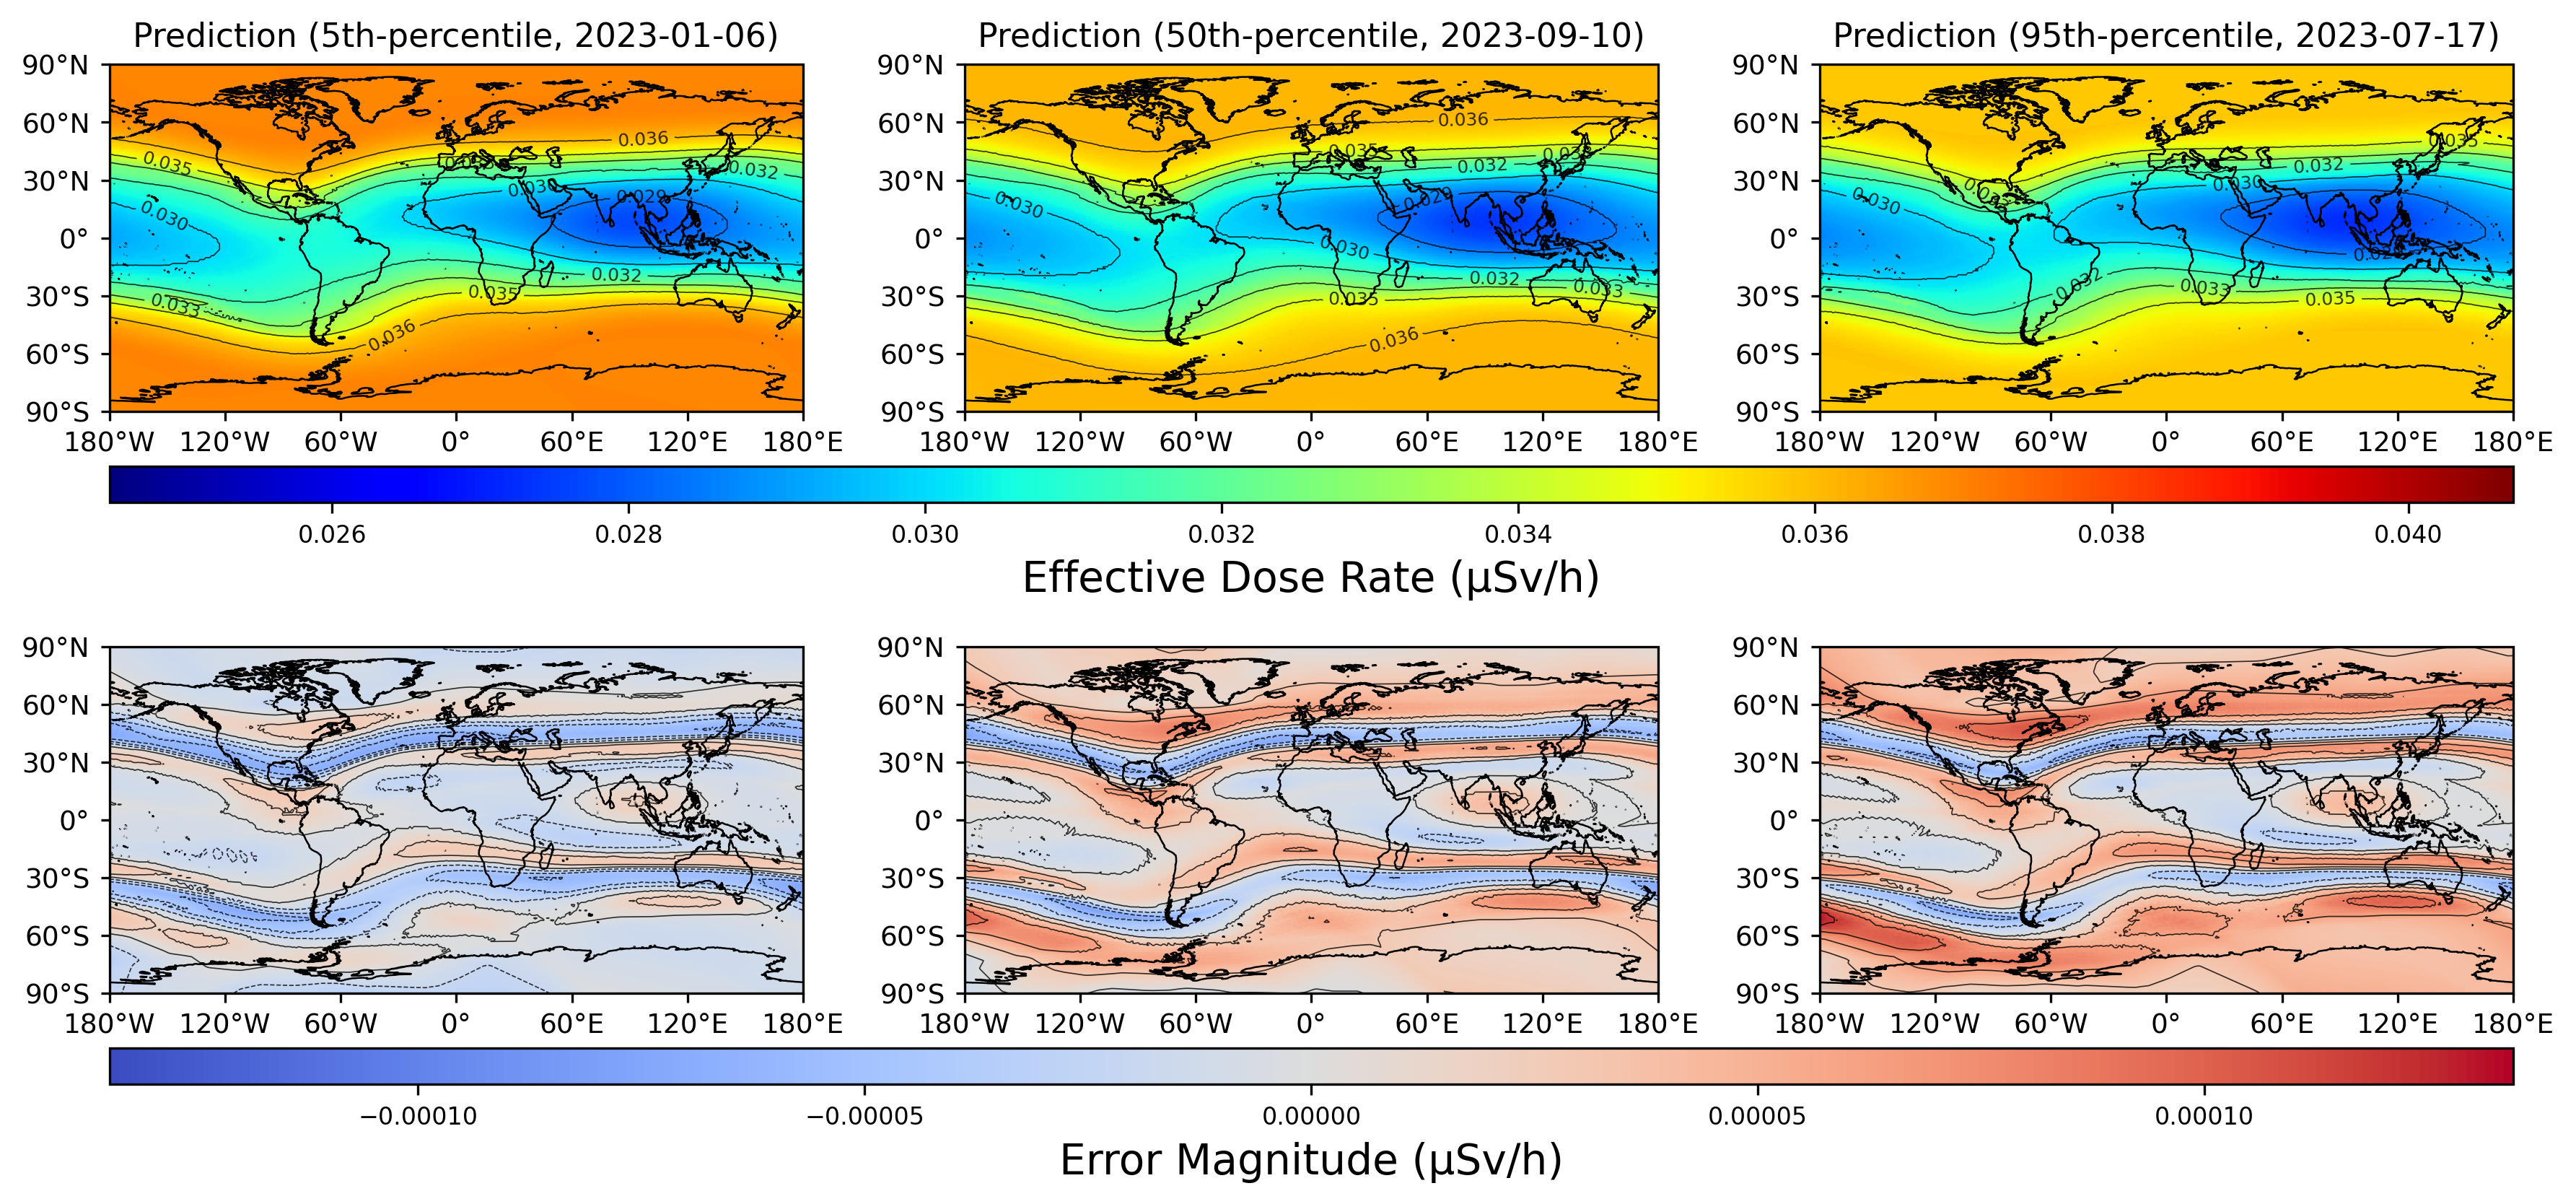

In [14]:
region = [-180, 180, -90, 90]              # or any subregion
plot_three_samples_pred_err(
    lon, lat, preds_2d, targets_2d, idxs,
    region_extent=region,
    units_pred="Effective Dose Rate (µSv/h)",
    units_err="Error Magnitude (µSv/h)",
    cmap_pred="jet",
    cmap_err="coolwarm",
    error_mode="diff",                     # or "abs"
    tick_step=(60, 30),
    contour_levels=6,
    show_borders=False,
    mark_equator_meridian=False,
    add_contour=True,
    vlim_err=None,
    #savepath="analysis/baseline/lstm_window_30_pred_err_maps.png",                          
)